In this kernel, I'll be using an object detection model (YOLOv3) to detect the location of the dogs within the images, followed by using the InceptionV3 model re-trained specifically on this dataset to classify the dogs into their unique breeds.

NOTE: As I'm unable to include the YOLO model in this kernel, this [link](https://github.com/gabrielloye/yolov3-stanford-dogs/blob/master/main.ipynb) to my repository includes the training script for YOLO and how it can be combined with the model trained in this kernel.

Any feedback on areas of improvement and better practices that I should adopt is definitely welcome.

In [1]:
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler, random_split
import torch.nn as nn

from PIL import Image
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xml.etree.ElementTree as ET

After importing the necessary modules, we'll first define a function that finds the bounding boxes using the maximum and minimum x and y values from the annotation files and crops the images accordingly

In [2]:
def crop_image(breed, dog, data_dir):
  img = plt.imread(data_dir + 'images/Images/' + breed + '/' + dog + '.jpg')
  tree = ET.parse(data_dir + 'annotations/Annotation/' + breed + '/' + dog)
  xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
  xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
  ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
  ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
  img = img[ymin:ymax, xmin:xmax, :]
  return img

To help visualise and ensure that we are cropping correctly, I've randomly chosen 4 images and displayed how the images are cropped with the annotations below.

n02089078-black-and-tan_coonhound
n02089078_2935
n02113186-Cardigan
n02113186_10891
n02106030-collie
n02106030_10246
n02098286-West_Highland_white_terrier
n02098286_840


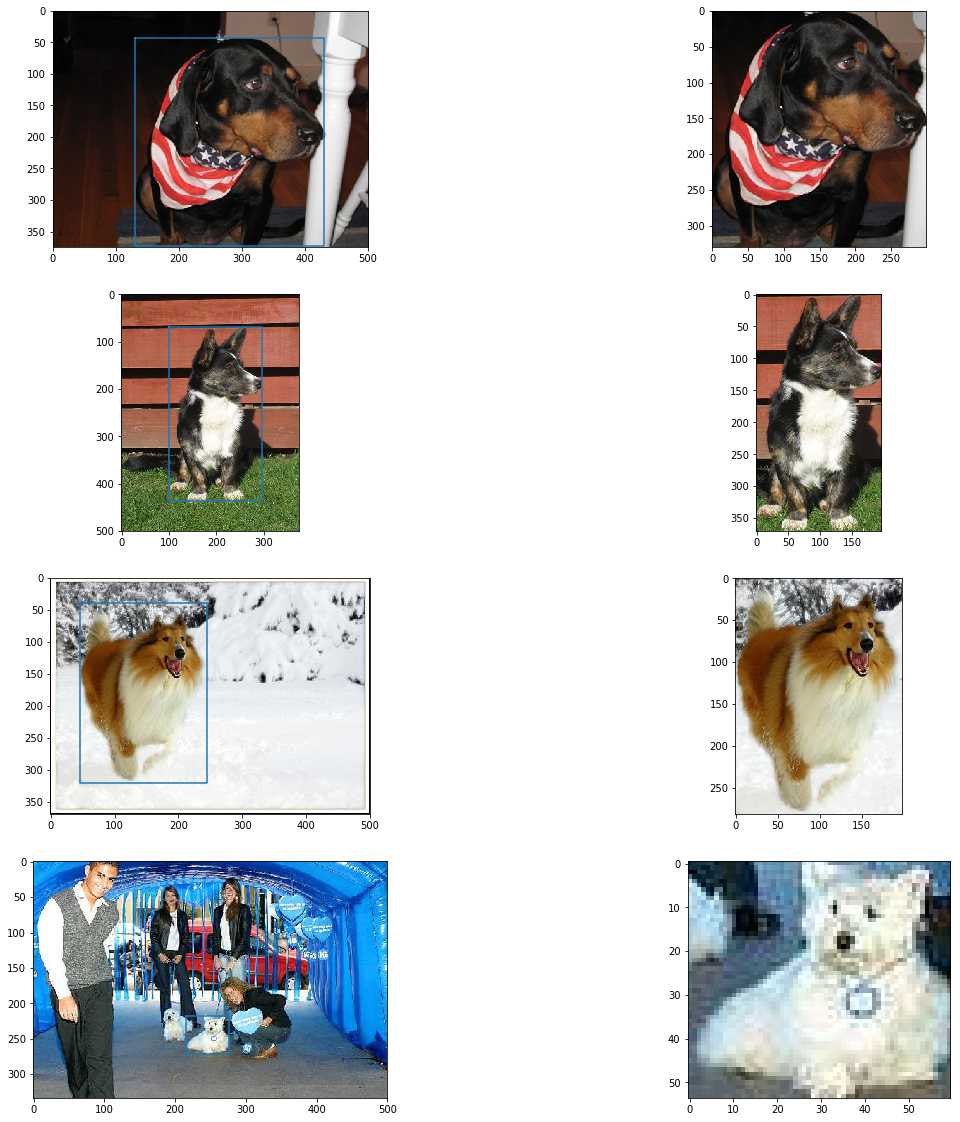

In [3]:
data_dir = '../input/stanford-dogs-dataset/'
breed_list = os.listdir(data_dir + 'images/Images/')

plt.figure(figsize=(20, 20))
for i in range(4):
  plt.subplot(421 + (i*2))
  breed = np.random.choice(breed_list)
  dog = np.random.choice(os.listdir(data_dir + 'annotations/Annotation/' + breed))
  print(breed)
  print(dog)
  img = plt.imread(data_dir + 'images/Images/' + breed + '/' + dog + '.jpg')
  plt.imshow(img)  
  
  tree = ET.parse(data_dir + 'annotations/Annotation/' + breed + '/' + dog)
  xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
  xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
  ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
  ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
  plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin])
  crop_img = crop_image(breed, dog, data_dir)
  plt.subplot(422 + (i*2))
  plt.imshow(crop_img)

Next, we'll create new folders to store all the cropped images, which we will use to train the classifier

In [4]:
if 'data' not in os.listdir():
    os.mkdir('data')
for breed in breed_list:
    os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

Created 120 folders to store cropped images of the different breeds.


And we'll save the cropped images to their breed folders

In [5]:
for breed in os.listdir('data'):
    for file in os.listdir(data_dir + 'annotations/Annotation/' + breed):
        img = Image.open(data_dir + 'images/Images/' + breed + '/' + file + '.jpg')
        tree = ET.parse(data_dir + 'annotations/Annotation/' + breed + '/' + file)
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin,ymin,xmax,ymax))
        img = img.convert('RGB')
        img.save('data/' + breed + '/' + file + '.jpg')

In [6]:
img_count = 0
for folder in os.listdir('data'):
    for _ in os.listdir('data/' + folder):
        img_count += 1
print('No. of Images: {}'.format(img_count))

No. of Images: 20580


Great, now all our cropped images are in place. We'll now define the data augmentation and normalizations for the data. The training data will have augmentations to increase the variability of training images. We'll use random rotations, random crops and some other augmentations for the training transforms. Both training and test data will then be resized to 299 * 299 as this is the standard input size for the inception model. The images will be normalized as well according to the ImageNet standards.



In [15]:
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=315, scale=(0.95, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=299),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=299),
        transforms.CenterCrop(size=299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

We'll now define the batch size (which can be modified depending on how you want to train your model) and split the data into training, validation and test sets.

In [16]:
#batch_size = 64
batch_size = 128

all_data = datasets.ImageFolder(root='data')
train_data_len = int(len(all_data)*0.8)
valid_data_len = int((len(all_data) - train_data_len)/2)
test_data_len = int(len(all_data) - train_data_len - valid_data_len)
train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
train_data.dataset.transform = image_transforms['train']
val_data.dataset.transform = image_transforms['test']
test_data.dataset.transform = image_transforms['test']
print(len(train_data), len(val_data), len(test_data))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


16464 2058 2058


In [17]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
print(features.shape, labels.shape)

torch.Size([128, 3, 299, 299]) torch.Size([128])


After making sure that our data loaders are outputting data of the correct dimensions (batch_size, 3, 299, 299), we can now instantiate the model by loading it with pre-trained weights. Specifically for the Inception model, we'll have to set the aux_logits property to False. We can then see the model architecture(which is very long).

In [18]:
model = models.inception_v3(pretrained=True)
model.aux_logits=False

#model = models.densenet161(pretrained=True)
#model = models.densenet121(pretrained=True)

model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

Next, we'll freeze the earlier layers in the model as we do not want to re-train these weights, which are responsible for the model's success in picking out key features of the image.

In [19]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

Instead, the only layers which we will be training is the classifier layer, or defined as the fc layer for the case of the Inception model. We have to ensure that the final output will be 120 as we have 120 possible different classes.

In [20]:
n_classes = 120

#n_inputs will be 4096 for this case
# Add on classifier

## For DenseNet
# n_inputs = model.classifier.in_features
# model.classifier = nn.Sequential(
#     nn.Linear(n_inputs, 1024),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(1024, n_classes),
#     nn.LogSoftmax(dim=1))

# model.classifier

## For Inception V3
n_inputs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(n_inputs, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, n_classes),
    nn.LogSoftmax(dim=1))

model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4)
  (3): Linear(in_features=1024, out_features=120, bias=True)
  (4): LogSoftmax()
)

Sending the model to GPU, if not it'll take forever to train. This is followed by defining the criterion and optimizer.

In [21]:
model.cuda()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Creating an index for the 120 different classes/breeds below

In [22]:
model.class_to_idx = all_data.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

[(0, 'n02085620-Chihuahua'),
 (1, 'n02085782-Japanese_spaniel'),
 (2, 'n02085936-Maltese_dog'),
 (3, 'n02086079-Pekinese'),
 (4, 'n02086240-Shih-Tzu'),
 (5, 'n02086646-Blenheim_spaniel'),
 (6, 'n02086910-papillon'),
 (7, 'n02087046-toy_terrier'),
 (8, 'n02087394-Rhodesian_ridgeback'),
 (9, 'n02088094-Afghan_hound'),
 (10, 'n02088238-basset'),
 (11, 'n02088364-beagle'),
 (12, 'n02088466-bloodhound'),
 (13, 'n02088632-bluetick'),
 (14, 'n02089078-black-and-tan_coonhound'),
 (15, 'n02089867-Walker_hound'),
 (16, 'n02089973-English_foxhound'),
 (17, 'n02090379-redbone'),
 (18, 'n02090622-borzoi'),
 (19, 'n02090721-Irish_wolfhound'),
 (20, 'n02091032-Italian_greyhound'),
 (21, 'n02091134-whippet'),
 (22, 'n02091244-Ibizan_hound'),
 (23, 'n02091467-Norwegian_elkhound'),
 (24, 'n02091635-otterhound'),
 (25, 'n02091831-Saluki'),
 (26, 'n02092002-Scottish_deerhound'),
 (27, 'n02092339-Weimaraner'),
 (28, 'n02093256-Staffordshire_bullterrier'),
 (29, 'n02093428-American_Staffordshire_terrier'),


Now, we'll define the training function which will run over the specified number of epochs. It will take the data from the train loader and update the weights of the fc layer according to the labels.

Every 2 epochs, the function will do validation using the data from the validation loader and ensure that the loss is still decreasing. If the loss stops decreasing for a certain number of epochs (which is defined through the early_stop hyper-parameter), the model will stop training and save the previous the best weights instead

In [23]:
def train(model,
         criterion,
         optimizer,
         train_loader,
         val_loader,
         save_location,
         early_stop=3,
         n_epochs=20,
         print_every=2):
    #Initializing some variables
    valid_loss_min = np.Inf
    stop_count = 0
    valid_max_acc = 0
    history = []
    model.epochs = 0

    #Loop starts here
    for epoch in range(n_epochs):
        
        train_loss = 0
        valid_loss = 0

        train_acc = 0
        valid_acc = 0

        model.train()
        ii = 0

        for data, label in train_loader:
            ii += 1
            data, label = data.cuda(), label.cuda()
            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1) # first output gives the max value in the row(not what we want), second output gives index of the highest val
            correct_tensor = pred.eq(label.data.view_as(pred)) # using the index of the predicted outcome above, torch.eq() will check prediction index against label index to see if prediction is correct(returns 1 if correct, 0 if not)
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor)) #tensor must be float to calc average
            train_acc += accuracy.item() * data.size(0)
            if ii%10 == 0:
                print(f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete.')

        model.epochs += 1
        with torch.no_grad():
            model.eval()

            for data, label in val_loader:
                data, label = data.cuda(), label.cuda()

                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item() * data.size(0)

                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(label.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                valid_acc += accuracy.item() * data.size(0)

            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(val_loader.dataset)

            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(val_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            if (epoch + 1) % print_every == 0:
                print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
                print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

            if valid_loss < valid_loss_min:
                torch.save({
                    'state_dict': model.state_dict(),
                    'idx_to_class': model.idx_to_class
                }, save_location)
                stop_count = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            else:
                stop_count += 1

                # Below is the case where we handle the early stop case
                if stop_count >= early_stop:
                    print(f'\nEarly Stopping Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')
                    model.load_state_dict(torch.load(save_location)['state_dict'])
                    model.optimizer = optimizer
                    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])
                    return model, history

    model.optimizer = optimizer
    print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')

    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [24]:
model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_location='./dog_inception.pt',
    early_stop=3,
    n_epochs=30,
    print_every=2)

Epoch: 0	8.53% complete.
Epoch: 0	16.28% complete.
Epoch: 0	24.03% complete.
Epoch: 0	31.78% complete.
Epoch: 0	39.53% complete.
Epoch: 0	47.29% complete.
Epoch: 0	55.04% complete.
Epoch: 0	62.79% complete.
Epoch: 0	70.54% complete.
Epoch: 0	78.29% complete.
Epoch: 0	86.05% complete.
Epoch: 0	93.80% complete.
Epoch: 1	8.53% complete.
Epoch: 1	16.28% complete.
Epoch: 1	24.03% complete.
Epoch: 1	31.78% complete.
Epoch: 1	39.53% complete.
Epoch: 1	47.29% complete.
Epoch: 1	55.04% complete.
Epoch: 1	62.79% complete.
Epoch: 1	70.54% complete.
Epoch: 1	78.29% complete.
Epoch: 1	86.05% complete.
Epoch: 1	93.80% complete.

Epoch: 1 	Training Loss: 1.0797 	Validation Loss: 0.8857
		Training Accuracy: 69.66%	 Validation Accuracy: 74.15%
Epoch: 2	8.53% complete.
Epoch: 2	16.28% complete.
Epoch: 2	24.03% complete.
Epoch: 2	31.78% complete.
Epoch: 2	39.53% complete.
Epoch: 2	47.29% complete.
Epoch: 2	55.04% complete.
Epoch: 2	62.79% complete.
Epoch: 2	70.54% complete.
Epoch: 2	78.29% complete.
Epoc

In [ ]:
history

After training for just a few epochs, we can see that the accuracy on the validation training set is around 75%. To ensure that the model isn't overfitting for the training and validation data, let's test the model out using the test data which it has not seen at all yet.

In [25]:
def test(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        test_acc = 0
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()

            output = model(data)

            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(label.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            test_acc += accuracy.item() * data.size(0)

        test_acc = test_acc / len(test_loader.dataset)
        return test_acc

In [26]:
model.load_state_dict(torch.load('./dog_inception.pt')['state_dict'])
test_acc = test(model.cuda(), test_loader, criterion)
print(f'The model has achieved an accuracy of {100 * test_acc:.2f}% on the test dataset')

The model has achieved an accuracy of 78.67% on the test dataset


The accuracy we achieved is not too bad considering that some dog breeds can be extremely similar and we may not be able to distinguish them with our eyes ourselves

In [39]:
def evaluate(model, test_loader, criterion):
  
    classes = []
    acc_results = np.zeros(len(test_loader.dataset))
    i = 0

    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.cuda(), labels.cuda()
            output = model(data)

            for pred, true in zip(output, labels):
                _, pred = pred.unsqueeze(0).topk(1)
                correct = pred.eq(true.unsqueeze(0))
                acc_results[i] = correct.cpu()
                classes.append(model.idx_to_class[true.item()][10:])
                i+=1

    results = pd.DataFrame({
      'class': classes,
      'results': acc_results    
    })
    results = results.groupby(classes).mean()
    # Print top 5 results 
    top5_results = results.nsmallest(10, 'results')
    return top5_results

In [28]:
print(evaluate(model, test_loader, criterion))

                                 results
Afghan_hound                    0.950000
African_hunting_dog             0.875000
Airedale                        0.909091
American_Staffordshire_terrier  0.625000
Appenzeller                     0.687500
Australian_terrier              0.583333
Bedlington_terrier              0.916667
Bernese_mountain_dog            0.950000
Blenheim_spaniel                0.913043
Border_collie                   0.937500
Border_terrier                  0.823529
Boston_bull                     0.933333
Bouvier_des_Flandres            0.611111
Brabancon_griffon               0.812500
Brittany_spaniel                0.888889
Cardigan                        0.736842
Chesapeake_Bay_retriever        0.727273
Chihuahua                       0.866667
Dandie_Dinmont                  0.941176
Doberman                        0.846154
English_foxhound                0.833333
English_setter                  0.733333
English_springer                0.785714
EntleBucher     

In [30]:
!pip install torchsummary

You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [31]:
from torchsummary import summary
summary(model, input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
           Conv2d-10           [-1, 80, 73, 73]           5,120
      BatchNorm2d-11           [-1, 80, 73, 73]             160
      BasicConv2d-12           [-1, 80, 73, 73]               0
           Conv2d-13          [-1, 192, 71, 71]         138,240
      BatchNorm2d-14          [-1, 192,

In [32]:
model.load_state_dict(torch.load('./dog_inception.pt')['state_dict'])

In [33]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [34]:
# Load it and set requires_Grad = True 
for i, param in enumerate(model.parameters()):
    param.requires_grad = True
print(i)

# Define the learning rate 
optimizer = optim.Adam(model.parameters(), lr=0.0001)

293


In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 299, 299))

In [35]:
# Train
model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_location='./dog_inception.pt',
    early_stop=3,
    n_epochs=30,
    print_every=2)

Epoch: 0	4.26% complete.
Epoch: 0	8.14% complete.
Epoch: 0	12.02% complete.
Epoch: 0	15.89% complete.
Epoch: 0	19.77% complete.
Epoch: 0	23.64% complete.
Epoch: 0	27.52% complete.
Epoch: 0	31.40% complete.
Epoch: 0	35.27% complete.
Epoch: 0	39.15% complete.
Epoch: 0	43.02% complete.
Epoch: 0	46.90% complete.
Epoch: 0	50.78% complete.
Epoch: 0	54.65% complete.
Epoch: 0	58.53% complete.
Epoch: 0	62.40% complete.
Epoch: 0	66.28% complete.
Epoch: 0	70.16% complete.
Epoch: 0	74.03% complete.
Epoch: 0	77.91% complete.
Epoch: 0	81.78% complete.
Epoch: 0	85.66% complete.
Epoch: 0	89.53% complete.
Epoch: 0	93.41% complete.
Epoch: 0	97.29% complete.
Epoch: 1	4.26% complete.
Epoch: 1	8.14% complete.
Epoch: 1	12.02% complete.
Epoch: 1	15.89% complete.
Epoch: 1	19.77% complete.
Epoch: 1	23.64% complete.
Epoch: 1	27.52% complete.
Epoch: 1	31.40% complete.
Epoch: 1	35.27% complete.
Epoch: 1	39.15% complete.
Epoch: 1	43.02% complete.
Epoch: 1	46.90% complete.
Epoch: 1	50.78% complete.
Epoch: 1	54.65% 

In [37]:

# Test
model.load_state_dict(torch.load('./dog_inception.pt')['state_dict'])
test_acc = test(model.cuda(), test_loader, criterion)
print(f'The model has achieved an accuracy of {100 * test_acc:.2f}% on the test dataset')



The model has achieved an accuracy of 83.97% on the test dataset


In [40]:
# Evaluate
print(evaluate(model, test_loader, criterion))

                    results
Eskimo_dog         0.230769
Siberian_husky     0.428571
Walker_hound       0.500000
collie             0.500000
Shetland_sheepdog  0.538462
miniature_poodle   0.571429
Appenzeller        0.625000
Norfolk_terrier    0.625000
giant_schnauzer    0.625000
kuvasz             0.625000


In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 299, 299))

The table above shows the accuracy of our model on the specific breeds, with a score of 1 showing that our model classified that breed correctly. As we can see, some of the breeds have rather bad accuracy, probably because of their similarities, which the model could not pick out the fine-grained differences.

To-Do:
- Improve the model by possibly unfreezing some layers and training them.

In [ ]:
!rm -rf  data/*
#deleting the data of the cropped images we saved earlier on so this notebook can be posted